In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import laspy
import os
import time


Total points: 389535
Deck points_raw: (89448, 7)
Deck points_test: (108981, 7)
原始的桥板长度: 6.09
原始的桥板宽度: 5.30
估计的桥板长度: 7.58
估计的桥板宽度: 5.33
Time: 6.35 s


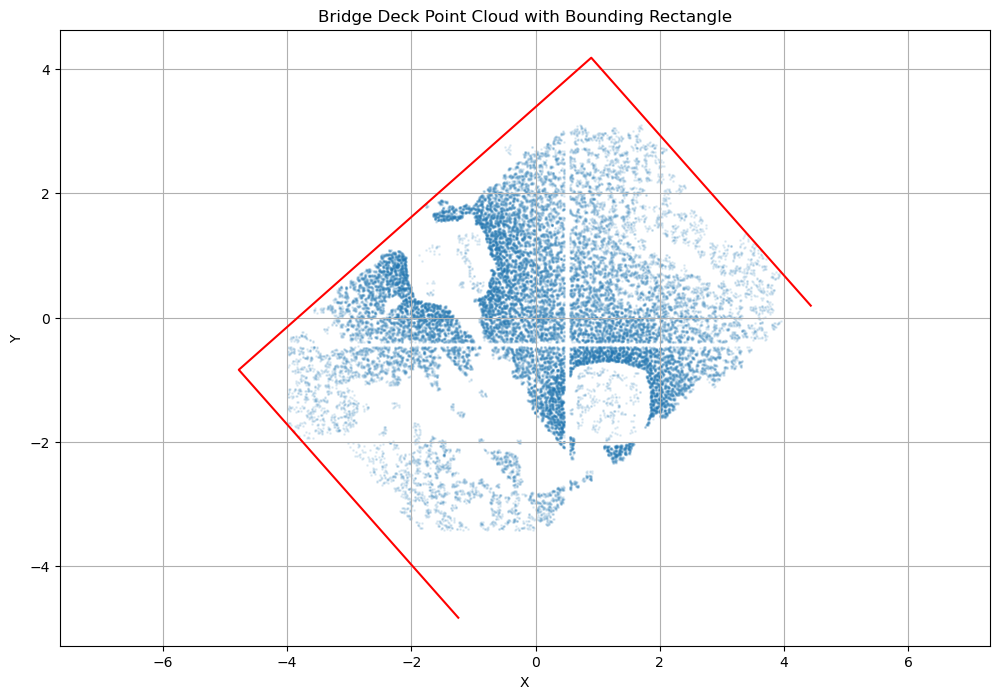

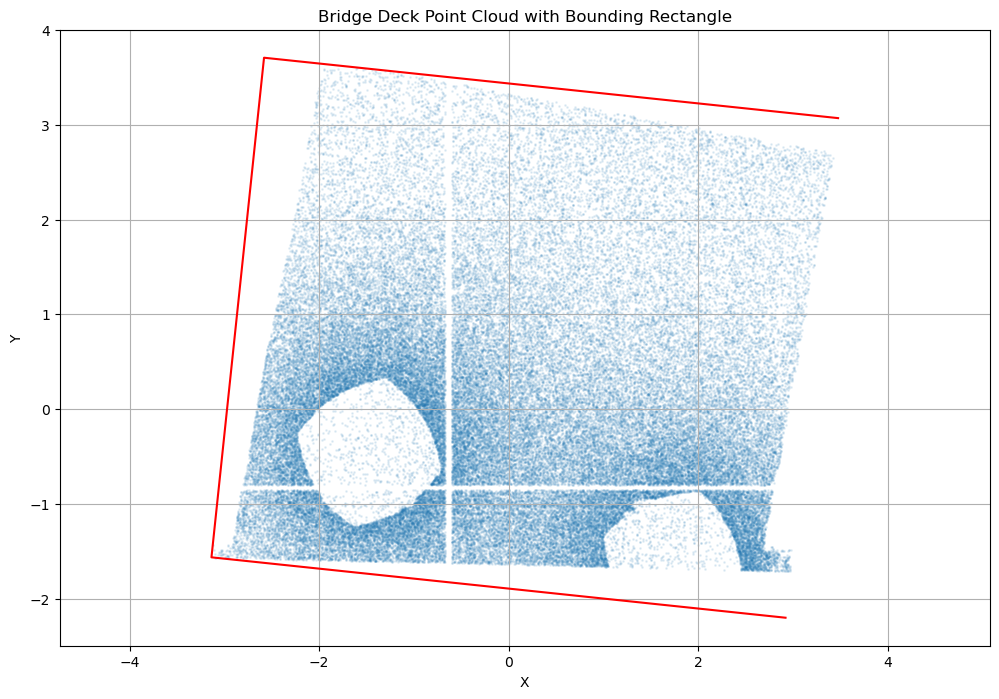

In [24]:
deck_raw, deck_test = load_data('Bridge4_0')

start_time = time.time()

result = deck_test

# 使用函数
#length_raw, width_raw = calculate_bridge_dimensions(deck_raw)
length_raw, width_raw, cleaned_points, bounding_rect = process_raw(deck_raw)
length, width, cleaned_points_test, bounding_rect_test = process_bridge_deck(deck_test)

print(f"原始的桥板长度: {length_raw:.2f}")
print(f"原始的桥板宽度: {width_raw:.2f}")

print(f"估计的桥板长度: {length:.2f}")
print(f"估计的桥板宽度: {width:.2f}")

end_time = time.time()
# 可视化
print(f"Time: {end_time - start_time:.2f} s")
#plot_deck(deck_test,'RANSAC')

# 可视化
plt.figure(figsize=(12, 8))
plt.scatter(cleaned_points_test[:, 0], cleaned_points_test[:, 1], alpha=0.1, s=1)
plt.plot(bounding_rect_test[:, 0], bounding_rect_test[:, 1], 'r-')
plt.title('Bridge Deck Point Cloud with Bounding Rectangle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.show()

# 可视化
plt.figure(figsize=(12, 8))
plt.scatter(cleaned_points[:, 0], cleaned_points[:, 1], alpha=0.1, s=1)
plt.plot(bounding_rect[:, 0], bounding_rect[:, 1], 'r-')
plt.title('Bridge Deck Point Cloud with Bounding Rectangle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.show()

In [23]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull

def load_data(name):
    
    pathraw=f"..\\data\\bridge-5cls-fukushima\\test\\{name}.txt"
    pathtest=f'log\\sem_seg\\2024-10-05_01-43\\visual\\{name}_pred.txt'
    # 读取数据
    data_raw = np.loadtxt(pathraw, delimiter=' ')
    data_test = np.loadtxt(pathtest, delimiter=' ')

    # 提取床板数据（label == 2）
    deck_raw = data_raw[data_raw[:, 6] == 2]
    deck_test = data_test[data_test[:, 6] == 2]


    # 提取x, y坐标（忽略z坐标）
    deck_raw_coords = deck_raw[:, :2]
    deck_test_coords = deck_test[:, :2]

    print(f"Total points: {data_test.shape[0]}")
    print(f"Deck points_raw: {deck_raw.shape}")
    print(f"Deck points_test: {deck_test.shape}")
    return deck_raw, deck_test

def ransac_plane_fit(points, max_trials=2000, residual_threshold=0.1):
    ransac = RANSACRegressor(max_trials=max_trials, residual_threshold=residual_threshold, random_state=42)
    ransac.fit(points[:, :2], points[:, 2])
    inlier_mask = ransac.inlier_mask_
    return points[inlier_mask]

def project_to_plane(points):
    return points[:, :2]

def align_to_principal_axes(points):
    pca = PCA(n_components=2)
    pca.fit(points)
    return pca.transform(points)

def detect_and_trim_edges(points, percentile=2):
    x, y = points[:, 0], points[:, 1]
    x_density, x_bins = np.histogram(x, bins=100)
    y_density, y_bins = np.histogram(y, bins=100)
    
    x_threshold = np.percentile(x_density, percentile)
    y_threshold = np.percentile(y_density, percentile)
    
    x_indices = np.clip(np.digitize(x, x_bins[1:-1]) - 1, 0, len(x_density) - 1)
    y_indices = np.clip(np.digitize(y, y_bins[1:-1]) - 1, 0, len(y_density) - 1)
    
    x_mask = np.logical_and(x_density[x_indices] > x_threshold, x_density[x_indices] < np.max(x_density))
    y_mask = np.logical_and(y_density[y_indices] > y_threshold, y_density[y_indices] < np.max(y_density))
    
    return points[np.logical_and(x_mask, y_mask)]

def minimum_bounding_rectangle(points):
    hull_points = points[ConvexHull(points).vertices]
    edges = np.subtract.outer(hull_points, hull_points).reshape(-1, 2)
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, np.pi/2))
    angles = np.unique(angles)
    
    rotations = np.vstack([np.cos(angles), -np.sin(angles), 
                           np.sin(angles), np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))
    
    rot_points = np.dot(rotations, hull_points.T)
    
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)
    
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)
    
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]
    
    rval = np.array([
        np.dot([x1, y2], r),
        np.dot([x2, y2], r),
        np.dot([x2, y1], r),
        np.dot([x1, y1], r)
    ])
    
    return rval

def data_voxel(data, voxel_size=0.1):

    bridge_points = data[:, :3]
    
    # 体素网格滤波
    voxel_coords = np.floor(bridge_points / voxel_size).astype(int)
    _, unique_indices = np.unique(voxel_coords, axis=0, return_index=True)
    filtered_points = bridge_points[unique_indices]
    
    return filtered_points

def isolation_forest_outlier_removal(points, contamination=0.1):
    from sklearn.ensemble import IsolationForest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_labels = iso_forest.fit_predict(points)
    
    inliers = points[outlier_labels == 1]
    outliers = points[outlier_labels == -1]
    
    return inliers

def lof_outlier_removal(points, n_neighbors=20, contamination='auto'):
    from sklearn.neighbors import LocalOutlierFactor
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outlier_labels = lof.fit_predict(points)
    
    inliers = points[outlier_labels == 1]
    
    return inliers

def dbscan_outlier_removal(points, eps=0.5, min_samples=5):
    import numpy as np
    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import StandardScaler
    # 标准化数据
    scaler = StandardScaler()
    points_scaled = scaler.fit_transform(points)

    # 应用DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(points_scaled)

    # 识别非离群点（即被分配到簇中的点）
    inliers = points[clusters != -1] # -1 表示离群点
    outliers = points[clusters == -1]

    return inliers

def process_bridge_deck(points):
    # 只使用 x, y, z 坐标
    result = points[:, :3]
    
    #下采样
    result = data_voxel(result, voxel_size=0.005)

    # 1. analysis
    result = ransac_plane_fit(result,2000,0.05)

    result = isolation_forest_outlier_removal(result, contamination=0.1)

    result = lof_outlier_removal(result, n_neighbors=10, contamination=0.4)

    result = dbscan_outlier_removal(result,eps=1,min_samples=3)

    result = project_to_plane(result)
    
    result = result

    # 2. 主方向对齐
    result = align_to_principal_axes(result)
    
    # 3. 边缘检测和修剪
    points_trimmed = detect_and_trim_edges(result)
    result= detect_and_trim_edges(result)

    # 4. 矩形拟合
    rect = minimum_bounding_rectangle(result)
    #rect = result

    # 计算长度和宽度
    #length, width = calculate_bridge_dimensions(rect)
    width = np.linalg.norm(rect[1] - rect[0])
    length = np.linalg.norm(rect[2] - rect[1])
    
    return max(width, length), min(width, length), points_trimmed, rect


def process_raw(points):
    # 只使用 x, y, z 坐标
    xyz_points = points[:, :3]
   
    result = project_to_plane(xyz_points)

    # 2. 主方向对齐
    result = align_to_principal_axes(result)
    
    # 3. 边缘检测和修剪
    points_trimmed = detect_and_trim_edges(result)
    result= detect_and_trim_edges(result)

    # 4. 矩形拟合
    rect = minimum_bounding_rectangle(result)

    # 计算长度和宽度
    #length, width = calculate_bridge_dimensions(rect)
    width = np.linalg.norm(rect[1] - rect[0])
    length = np.linalg.norm(rect[2] - rect[1])
    
    return max(width, length), min(width, length), points_trimmed, rect

    



In [25]:
def evaluate_result(length_raw, width_raw, length_processed, width_processed):
    length_error = abs(length_raw - length_processed) / length_raw
    width_error = abs(width_raw - width_processed) / width_raw
    return (length_error + width_error) / 2  # 平均相对误差


In [ ]:
import itertools

def optimize_process_bridge_deck(deck_raw, deck_test):
    length_raw, width_raw, _, _ = process_raw(deck_raw)
    
    best_error = float('inf')
    best_params = None
    best_functions = None

    # 定义参数范围
    voxel_sizes = [0.005, 0.01, 0.02]
    ransac_trials = [1000, 2000, 3000]
    ransac_thresholds = [0.05, 0.1, 0.2]
    iso_contaminations = [0.05, 0.1, 0.2]
    lof_neighbors = [5, 10, 20]
    lof_contaminations = [0.1, 0.2, 0.3, 0.4]
    dbscan_eps = [0.5, 1, 1.5]
    dbscan_min_samples = [3, 5, 7]

    # 所有可能的函数组合
    function_combinations = [
        [data_voxel, ransac_plane_fit, isolation_forest_outlier_removal, lof_outlier_removal, dbscan_outlier_removal],
        [data_voxel, ransac_plane_fit, isolation_forest_outlier_removal, lof_outlier_removal],
        [data_voxel, ransac_plane_fit, isolation_forest_outlier_removal, dbscan_outlier_removal],
        [data_voxel, ransac_plane_fit, lof_outlier_removal, dbscan_outlier_removal],
        [data_voxel, isolation_forest_outlier_removal, lof_outlier_removal, dbscan_outlier_removal],
        [data_voxel, ransac_plane_fit, isolation_forest_outlier_removal],
        [data_voxel, ransac_plane_fit, lof_outlier_removal],
        [data_voxel, ransac_plane_fit, dbscan_outlier_removal],
        [data_voxel, isolation_forest_outlier_removal, lof_outlier_removal],
        [data_voxel, isolation_forest_outlier_removal, dbscan_outlier_removal],
        [data_voxel, lof_outlier_removal, dbscan_outlier_removal]
    ]

    for functions in function_combinations:
        for params in itertools.product(voxel_sizes, ransac_trials, ransac_thresholds, 
                                        iso_contaminations, lof_neighbors, lof_contaminations, 
                                        dbscan_eps, dbscan_min_samples):
            voxel_size, ransac_trial, ransac_threshold, iso_contamination, lof_neighbor, lof_contamination, dbscan_ep, dbscan_min_sample = params
            
            def process_bridge_deck_temp(points):
                result = points[:, :3]
                for func in functions:
                    if func == data_voxel:
                        result = func(result, voxel_size=voxel_size)
                    elif func == ransac_plane_fit:
                        result = func(result, max_trials=ransac_trial, residual_threshold=ransac_threshold)
                    elif func == isolation_forest_outlier_removal:
                        result = func(result, contamination=iso_contamination)
                    elif func == lof_outlier_removal:
                        result = func(result, n_neighbors=lof_neighbor, contamination=lof_contamination)
                    elif func == dbscan_outlier_removal:
                        result = func(result, eps=dbscan_ep, min_samples=dbscan_min_sample)
                
                result = project_to_plane(result)
                result = align_to_principal_axes(result)
                result = detect_and_trim_edges(result)
                rect = minimum_bounding_rectangle(result)
                
                width = np.linalg.norm(rect[1] - rect[0])
                length = np.linalg.norm(rect[2] - rect[1])
                return max(width, length), min(width, length), result, rect

            length, width, _, _ = process_bridge_deck_temp(deck_test)
            error = evaluate_result(length_raw, width_raw, length, width)
            
            if error < best_error:
                best_error = error
                best_params = params
                best_functions = functions

    return best_functions, best_params, best_error

# 使用优化函数
best_functions, best_params, best_error = optimize_process_bridge_deck(deck_raw, deck_test)

print("Best functions:", [func.__name__ for func in best_functions])
print("Best parameters:", best_params)
print("Best error:", best_error)

# 使用最佳参数创建最终的 process_bridge_deck 函数
def optimized_process_bridge_deck(points):
    voxel_size, ransac_trial, ransac_threshold, iso_contamination, lof_neighbor, lof_contamination, dbscan_ep, dbscan_min_sample = best_params
    
    result = points[:, :3]
    for func in best_functions:
        if func == data_voxel:
            result = func(result, voxel_size=voxel_size)
        elif func == ransac_plane_fit:
            result = func(result, max_trials=ransac_trial, residual_threshold=ransac_threshold)
        elif func == isolation_forest_outlier_removal:
            result = func(result, contamination=iso_contamination)
        elif func == lof_outlier_removal:
            result = func(result, n_neighbors=lof_neighbor, contamination=lof_contamination)
        elif func == dbscan_outlier_removal:
            result = func(result, eps=dbscan_ep, min_samples=dbscan_min_sample)
    
    result = project_to_plane(result)
    result = align_to_principal_axes(result)
    points_trimmed = detect_and_trim_edges(result)
    rect = minimum_bounding_rectangle(points_trimmed)
    
    width = np.linalg.norm(rect[1] - rect[0])
    length = np.linalg.norm(rect[2] - rect[1])
    return max(width, length), min(width, length), points_trimmed, rect

# 测试优化后的函数
length, width, cleaned_points_test, bounding_rect_test = optimized_process_bridge_deck(deck_test)
print("Optimized results:")
print("Length:", length)
print("Width:", width)
